# Load Audio And Inspect Basics

In [2]:
from pydub import AudioSegment

In [3]:
audio = AudioSegment.from_file('Adiye.mp3')

In [5]:
print(f"Duration (ms): {len(audio)}")
print(f"Channels: {audio.channels}")
print(f"Frame rate: {audio.frame_rate}")
print(f"Sample Width (bytes): {audio.sample_width}")
print(f"dBFS (average Loudness): {audio.dBFS}")

Duration (ms): 272022
Channels: 2
Frame rate: 44100
Sample Width (bytes): 2
dBFS (average Loudness): -12.408286750147903


## Slicing Audio

In [6]:
First5sec = audio[:5000]
Next5sec = audio[5000:10000]
print(f"First 5 sec duration: {len(First5sec)}")
print(f"Next 5 sec duration: {len(Next5sec)}")

First 5 sec duration: 5000
Next 5 sec duration: 5000


## Fade In/Fade out Demo

In [11]:
fadeInClip = audio[:5000].fade_in(3000)
fadeOutClip = audio[:5000].fade_out(3000)

print(fadeInClip)
print(fadeOutClip)

In [12]:
print("camelCaseingWords")
print("PascleCasingWords")
print("snake_casing_words")
print("kebab-casing-words")

camelCaseingWords
PascleCasingWords
snake_casing_words
kebab-casing-words


# Concatenation Demo

## how to join two songs

In [13]:
concatenate = fadeInClip+fadeOutClip
print(f'{len(concatenate)}')

10000


# SIMPLE Waveform Plot using Librosa + Matplotlib

In [14]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline


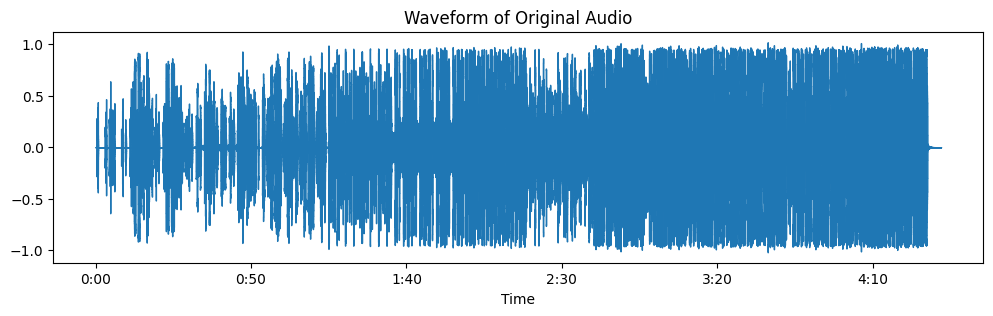

In [15]:
y ,sr =librosa.load('Adiye.mp3', sr=None)

plt.figure(figsize=(12,3))
librosa.display.waveshow(y,sr=sr)
plt.title("Waveform of Original Audio")
plt.show()

# Visualize Fade-IN and Fade-OUT

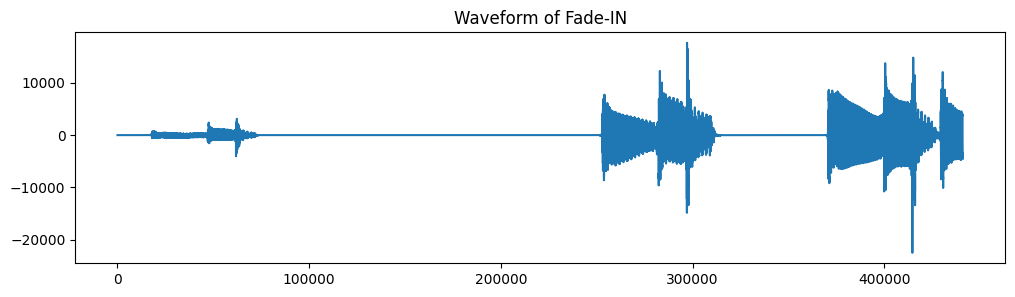

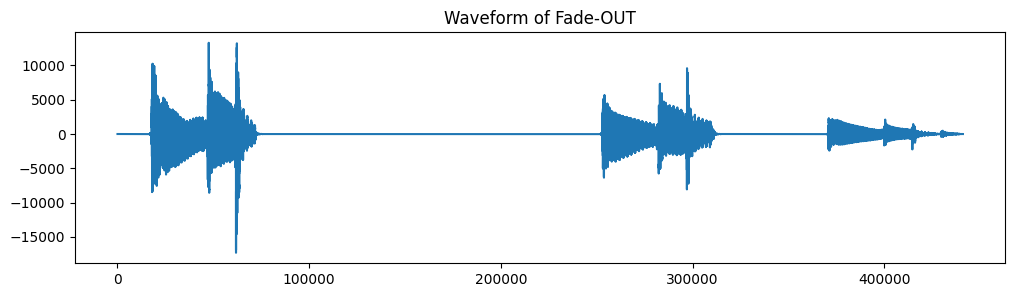

In [16]:
fadeInAudio=fadeInClip.get_array_of_samples()
fadeOutAudio=fadeOutClip.get_array_of_samples()

plt.figure(figsize=(12,3))
plt.plot(fadeInAudio)
plt.title("Waveform of Fade-IN")
plt.show()

plt.figure(figsize=(12,3))
plt.plot(fadeOutAudio)
plt.title("Waveform of Fade-OUT")
plt.show()

# LOGIC

In [39]:
import os
import random
import datetime
from pydub import AudioSegment
from pydub.utils import mediainfo

In [31]:
def smoothFadeMixtape(folder, output='output/mixtape.mp3',transition_ms=6000):
    files = [f for f in os.listdir(folder) if f.endswith((".mp3",".wav"))]
    
    random.shuffle(files)
    print(files)

    mixtape = None
    for i, file in enumerate(files):
        song = AudioSegment.from_file(os.path.join(folder,file))
        
        song=song.set_channels(2).set_frame_rate(44100)

        if mixtape is None:
            mixtape = song

        else:
            #define overlap region
            overlap=min(transition_ms,len(song),len(mixtape))
            #outgoing: fade out +highpass to remove bass
            outgoing=mixtape[-overlap:].fade_out(overlap).high_pass_filter(4000)
            #incoming: fadein + low-pass to smooth highs
            incoming=song[:overlap].fade_in(overlap).low_pass_filter(4000)
            #overlaying transition
            transition=outgoing.overlay(incoming)
            mixtape=mixtape[:-overlap]+transition+song[overlap:]

    mixtape.export(output,format="mp3")
    print(f"✅ Smooth fade mixtape generate: {output}")



In [32]:
smoothFadeMixtape("mixtape")

['Yennachu-Yedhachu.mp3', 'Adiye.mp3', 'Ennai-Vittu.mp3']
✅ Smooth fade mixtape generate: output/mixtape.mp3


In [38]:
import os
import random
import datetime
from pydub import AudioSegment
from pydub.utils import mediainfo

def get_song_metadata(filepath):
    """Extracts metadata; uses filename if tags are empty."""
    info = mediainfo(filepath)
    title = info.get("TAG", {}).get("title", os.path.basename(filepath).split('.')[0])
    duration_ms = int(float(info.get("duration", 0)) * 1000)
    return title, duration_ms

def apply_pro_transition(outgoing, incoming, overlap_ms):
    """
    Combines Smart EQ, Ducking, and Constant Power Crossfades.
    """
    # 1. SMART EQUALIZATION (The Frequency Handshake)
    # Outgoing: Kill the bass (Low-end) so it doesn't clash with the new track
    out_mid_high = outgoing.high_pass_filter(1300).fade_out(overlap_ms)
    
    # Incoming: Start with just the bass/warmth, then bring in the melody
    in_bass_intro = incoming.low_pass_filter(1000).fade_in(overlap_ms)
    
    # 2. DUCKING / SIDECHAINING
    # We slightly lower the volume of the outgoing mids to let the incoming track 'pop'
    out_ducked = out_mid_high - 3.0 

    # 3. CONSTANT POWER OVERLAY
    # Adding +2.5dB during overlay prevents the 'volume dip' in the middle
    return out_ducked.overlay(in_bass_intro, gain_during_overlay=2.5)

def apply_echo_out(audio_seg, delay_ms=1000, decay_db=8):
    """Applies a professional echo/delay effect to the very end of the mix."""
    tail = audio_seg[-2000:]
    echo = tail.overlay(tail - decay_db, position=delay_ms).overlay(tail - (decay_db*2), position=delay_ms*2)
    return audio_seg[:-2000] + echo.fade_out(2000)

def generate_youtube_metadata(song_data):
    """Creates a timestamped tracklist for YouTube Chapters."""
    title = f"Seamless AI Mixtape {datetime.date.today().year} | High-Fidelity Audio Mix"
    
    description = ["🚀 Professional Mix generated with AI Transition Logic.\n", "📌 TRACKLIST:"]
    description.append("""✨ HIGHLIGHTS
- Smooth 6-second crossfades using high-pass/low-pass filtering.
- 320kbps High-Fidelity audio quality.
- Curated for a consistent BPM flow. \n""")
    current_time_ms = 0
    
    for song in song_data:
        # Format: 00:00:00 -> 00:00
        timestamp = str(datetime.timedelta(seconds=current_time_ms//1000)).split(".")[0].zfill(8)[3:]
        description.append(f"{timestamp} - {song['name']}")
        current_time_ms += (song['duration'] - song['overlap'])

    description.append("\n#DJMix #AudioAutomation #PythonProject #STEMOPT #Seamless")
    return title, "\n".join(description)

def create_pro_mixtape(folder, output='output/mixtape_final.mp3', transition_ms=8000):
    files = [f for f in os.listdir(folder) if f.endswith((".mp3", ".wav"))]
    random.shuffle(files)

    mixtape = None
    tracklist_data = []
    
    for i, file in enumerate(files):
        path = os.path.join(folder, file)
        song_name, duration = get_song_metadata(path)
        song = AudioSegment.from_file(path).set_channels(2).set_frame_rate(44100).normalize()

        if mixtape is None:
            mixtape = song
            tracklist_data.append({"name": song_name, "duration": duration, "overlap": 0})
        else:
            overlap = min(transition_ms, len(song) // 3, len(mixtape) // 3)
            
            # Extract transition segments
            outgoing_seg = mixtape[-overlap:]
            incoming_seg = song[:overlap]
            
            # Apply the Pro DJ Logic
            bridge = apply_pro_transition(outgoing_seg, incoming_seg, overlap)
            
            mixtape = mixtape[:-overlap] + bridge + song[overlap:]
            tracklist_data[-1]["overlap"] = overlap
            tracklist_data.append({"name": song_name, "duration": duration, "overlap": 0})

    # Apply Final Echo Out to the very end of the mixtape
    mixtape = apply_echo_out(mixtape)

    # Export & Metadata
    os.makedirs(os.path.dirname(output), exist_ok=True)
    mixtape.export(output, format="mp3", bitrate="320k")
    
    yt_title, yt_desc = generate_youtube_metadata(tracklist_data)
    print(f"\n--- YOUTUBE TITLE ---\n{yt_title}\n\n--- DESCRIPTION ---\n{yt_desc}")

if __name__ == "__main__":
    create_pro_mixtape("mixtape")


--- YOUTUBE TITLE ---
Seamless AI Mixtape 2026 | High-Fidelity Audio Mix

--- DESCRIPTION ---
🚀 Professional Mix generated with AI Transition Logic.

📌 TRACKLIST:
✨ HIGHLIGHTS
- Smooth 6-second crossfades using high-pass/low-pass filtering.
- 320kbps High-Fidelity audio quality.
- Curated for a consistent BPM flow. 

00:00 - Ennai Vittu - MassTamilan.dev
03:56 - Yennachu Yedhachu - MassTamilan.com
09:07 - Adiye - MassTamilan.fm

#DJMix #AudioAutomation #PythonProject #STEMOPT #Seamless


# Video Generator

In [44]:
import subprocess
import os
from PIL import Image

In [ ]:
def makeVideo(imagePath, audioPath, outputPath='output/mixV1.mp4',videoRes=(1920,1080),fps=1, preset='ultrafast'):
    if not os.path.exists(imagePath):
        raise FileNotFoundError(f"Image not found {imagePath}")
    if not os.path.exists(audioPath):
        raise FileNotFoundError(f"Audio not found: {audioPath}")
    
    os.makedirs(os.path.dirname(outputPath),exist_ok=True)

    # Resize the image
    imgResize = 'tempImg.jpeg'
    img=Image.open(imagePath)
    img=img.resize(videoRes)
    img.save(imgResize)

    #FFmpeg command
    cmd=[
        'ffmpeg',
        '-y',
        '-loop','1',
        '-i',imgResize,
        '-i',audioPath,
        '-c:v','libx264',
        '-preset',preset,
        '-tune','stillimage',
        '-r',str(fps),
        '-c:a','aac',
        '-b:a','320k',
        '-shortest',
        outputPath
    ]

    try:
        subprocess.run(cmd, check=True)
        print(f'✅ Video Created: {outputPath}')
    except subprocess.CalledProcessError as e:
        print(f"❌ FFmpeg failed! Error: {e}")
    finally:
        if os.path.exists(imgResize):
            os.remove(imgResize)



In [46]:
imge=r"images/eran.jpeg"
audi=r"output/mixtape_final.mp3"
makeVideo(imge,audi)

ffmpeg version 7.0 Copyright (c) 2000-2024 the FFmpeg developers
  built with Apple clang version 13.1.6 (clang-1316.0.21.2.5)
  configuration: --prefix=/Volumes/tempdisk/sw --extra-cflags=-fno-stack-check --arch=arm64 --cc=/usr/bin/clang --enable-gpl --enable-libvmaf --enable-libopenjpeg --enable-libopus --enable-libmp3lame --enable-libx264 --enable-libx265 --enable-libvpx --enable-libwebp --enable-libass --enable-libfreetype --enable-fontconfig --enable-libtheora --enable-libvorbis --enable-libsnappy --enable-libaom --enable-libvidstab --enable-libzimg --enable-libsvtav1 --enable-libharfbuzz --enable-libkvazaar --pkg-config-flags=--static --enable-ffplay --enable-postproc --enable-neon --enable-runtime-cpudetect --disable-indev=qtkit --disable-indev=x11grab_xcb
  libavutil      59.  8.100 / 59.  8.100
  libavcodec     61.  3.100 / 61.  3.100
  libavformat    61.  1.100 / 61.  1.100
  libavdevice    61.  1.100 / 61.  1.100
  libavfilter    10.  1.100 / 10.  1.100
  libswscale      8. 

✅ Video Created: output/mixV1.mp4


[out#0/mp4 @ 0x147104280] video:6591KiB audio:32249KiB subtitle:0KiB other streams:0KiB global headers:0KiB muxing overhead: 0.387168%
frame=  835 fps= 11 q=-1.0 Lsize=   38990KiB time=00:13:39.73 bitrate= 389.6kbits/s dup=0 drop=20228 speed=10.5x    
[libx264 @ 0x14561b5b0] frame I:4     Avg QP: 5.00  size:929694
[libx264 @ 0x14561b5b0] frame P:831   Avg QP: 1.24  size:  3645
[libx264 @ 0x14561b5b0] mb I  I16..4: 100.0%  0.0%  0.0%
[libx264 @ 0x14561b5b0] mb P  I16..4:  0.0%  0.0%  0.0%  P16..4:  5.8%  0.0%  0.0%  0.0%  0.0%    skip:94.2%
[libx264 @ 0x14561b5b0] coded y,uvDC,uvAC intra: 97.0% 95.8% 81.8% inter: 2.0% 0.9% 0.8%
[libx264 @ 0x14561b5b0] i16 v,h,dc,p: 26% 26% 23% 25%
[libx264 @ 0x14561b5b0] i8c dc,h,v,p: 31% 24% 23% 22%
[libx264 @ 0x14561b5b0] kb/s:64.65
[aac @ 0x14561ea30] Qavg: 11832.312


In [ ]:
import streamlit as st
import requests

st.set_page_config(page_title="AI Mixtape Generator", layout="centered")

st.title("🎵 YouTube Mixtape Automator")

# Project Name Input
vidname = st.text_input("Enter Video Name", placeholder="e.g., Summer_LoFi_2026")

# File Uploaders
bg_image = st.file_uploader("Upload Background Image", type=["jpg", "jpeg", "png"])
audio_files = st.file_uploader("Upload Songs", type=["mp3", "wav"], accept_multiple_files=True)

if st.button("🚀 Generate Mixtape"):
    if bg_image and audio_files and vidname:
        # Sanitize name (replace spaces with underscores)
        clean_name = vidname.replace(" ", "_")
        
        with st.spinner("Cooking your mixtape..."):
            files = [('bg_image', (bg_image.name, bg_image.getvalue(), bg_image.type))]
            for audio in audio_files:
                files.append(('songs', (audio.name, audio.getvalue(), audio.type)))
            
            # Sending the vidname as a form data parameter
            data = {'project_name': clean_name}
            
            try:
                response = requests.post("http://localhost:8000/process", files=files, data=data)
                if response.status_code == 200:
                    res = response.json()
                    st.success(f"✅ '{vidname}' is ready!")
                    
                    st.text_area("YouTube Description:", res['description'], height=200)

                    # Show Video Preview
                    video_url = f"http://localhost:8000/download/{res['video_file']}"
                    st.video(video_url)

                    # --- DOWNLOAD BUTTONS ---
                    col1, col2 = st.columns(2)
                    
                    # Fetch files from backend to provide as downloads
                    mp3_data = requests.get(f"http://localhost:8000/download/{res['audio_file']}").content
                    mp4_data = requests.get(video_url).content

                    with col1:
                        st.download_button("⬇️ Download MP3", data=mp3_data, file_name=f"{clean_name}.mp3")
                    with col2:
                        st.download_button("⬇️ Download MP4", data=mp4_data, file_name=f"{clean_name}.mp4")

                else:
                    st.error("Server error. Check if backend is running.")
            except Exception as e:
                st.error(f"Connection Error: {e}")
    else:
        st.warning("Please provide a name, an image, and songs.")